In [ ]:
using_colab = True

if using_colab:
    from google.colab import drive

    drive.mount('/content/drive')

    !pip uninstall torch torchvision torchaudio fastai timm thinc -y
    !pip purge cache

    !pip install monai

    !mkdir -p data

    !cp -r "/content/drive/MyDrive/MedSeg_3DUnet/imagesTr" data/
    !cp -r "/content/drive/MyDrive/MedSeg_3DUnet/labels" data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import random
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    Orientationd, SpatialPadd, ToTensord
)

images = sorted(glob.glob('data/imagesTr/*.nii.gz'))
labels = sorted(glob.glob('data/labels/*.nii.gz'))

data_dicts = [{"image": img, "label": lbl}
              for img, lbl in zip(images, labels)]

random.seed(42)
random.shuffle(data_dicts)

split_idx = int(0.9 * len(data_dicts))
train_data = data_dicts[:split_idx]
test_data = data_dicts[split_idx:]

common_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    SpatialPadd(keys=["image", "label"], spatial_size=(240, 240, 160)),
    ToTensord(keys=["image", "label"]),
])

train_ds = Dataset(data=train_data, transform=common_transforms)
test_ds = Dataset(data=test_data, transform=common_transforms)

train_loader = DataLoader(train_ds, batch_size=3, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=3, shuffle=False)


In [ ]:
# Sanity check shpaes
batch = next(iter(train_loader))

image, label = batch["image"], batch["label"]

print("Image shape:", image.shape)
print("Label shape:", label.shape)

Image shape: torch.Size([3, 4, 240, 240, 160])
Label shape: torch.Size([3, 1, 240, 240, 160])


In [ ]:
from monai.networks.nets import UNet
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=4,                    # from the 4 modalities
    out_channels=4,                   # number of segmentation classes, e.g. background + tumor
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


In [ ]:
from monai.losses import DiceCELoss
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
import os

# Define loss and optimizer
loss_function = DiceCELoss(
    to_onehot_y=True,
    softmax=True,
    include_background=False
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epoch_losses = []

print(f"Number of batches: {len(train_loader)}")
for epoch in range(10):
    model.train()
    epoch_loss = 0
    num_batches = len(train_loader)

    for i, batch_data in enumerate(train_loader):
        try:
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            print(f"Batch {i}, Loss: {loss.item():.6f}")
            epoch_loss += loss.item()

        except Exception as e:
            print(f"Error in batch {i}, skipping this batch: {e}")
            continue

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Average Loss: {epoch_loss:.8f}")
    if (epoch + 1) % 5 == 0:
        save_path = f"/content/drive/MyDrive/MedSeg_3DUnet/Saved_models/U-NET_3d-MEDSEG_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)

Number of batches: 145
Batch 0, Loss: 2.487679
Batch 1, Loss: 2.467297
Batch 2, Loss: 2.443837
Batch 3, Loss: 2.414586
Batch 4, Loss: 2.409570
Batch 5, Loss: 2.386071
Batch 6, Loss: 2.366779
Batch 7, Loss: 2.367734
Batch 8, Loss: 2.350947
Batch 9, Loss: 2.328377
Batch 10, Loss: 2.326803
Batch 11, Loss: 2.317147
Batch 12, Loss: 2.299212
Batch 13, Loss: 2.295579
Batch 14, Loss: 2.283238
Batch 15, Loss: 2.282091
Batch 16, Loss: 2.269433
Batch 17, Loss: 2.257362
Batch 18, Loss: 2.253489
Batch 19, Loss: 2.241930
Batch 20, Loss: 2.236011
Batch 21, Loss: 2.227202
Batch 22, Loss: 2.227849
Batch 23, Loss: 2.221296
Batch 24, Loss: 2.208701
Batch 25, Loss: 2.195652
Batch 26, Loss: 2.191741
Batch 27, Loss: 2.187221
Batch 28, Loss: 2.181223
Batch 29, Loss: 2.174726
Batch 30, Loss: 2.173643
Batch 31, Loss: 2.163076
Batch 32, Loss: 2.158792
Batch 33, Loss: 2.152987
Batch 34, Loss: 2.151353
Batch 35, Loss: 2.140010
Batch 36, Loss: 2.125894
Batch 37, Loss: 2.129336
Batch 38, Loss: 2.129574
Batch 39, Lo

In [ ]:
save_path = '/content/drive/MyDrive/MedSeg_3DUnet/Saved_models/U-NET_3d-MEDSEG_FULL.pth'
torch.save(model.state_dict(), save_path)

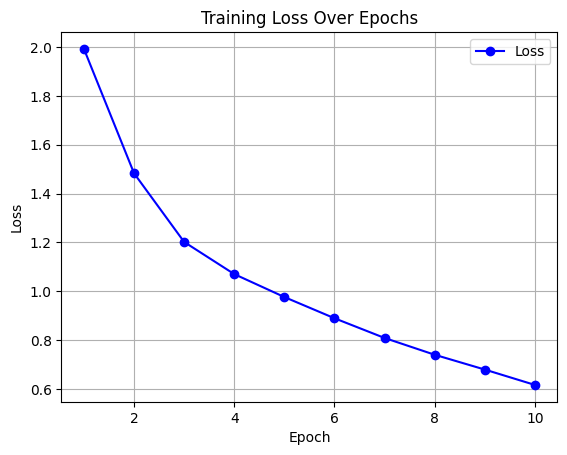

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), epoch_losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

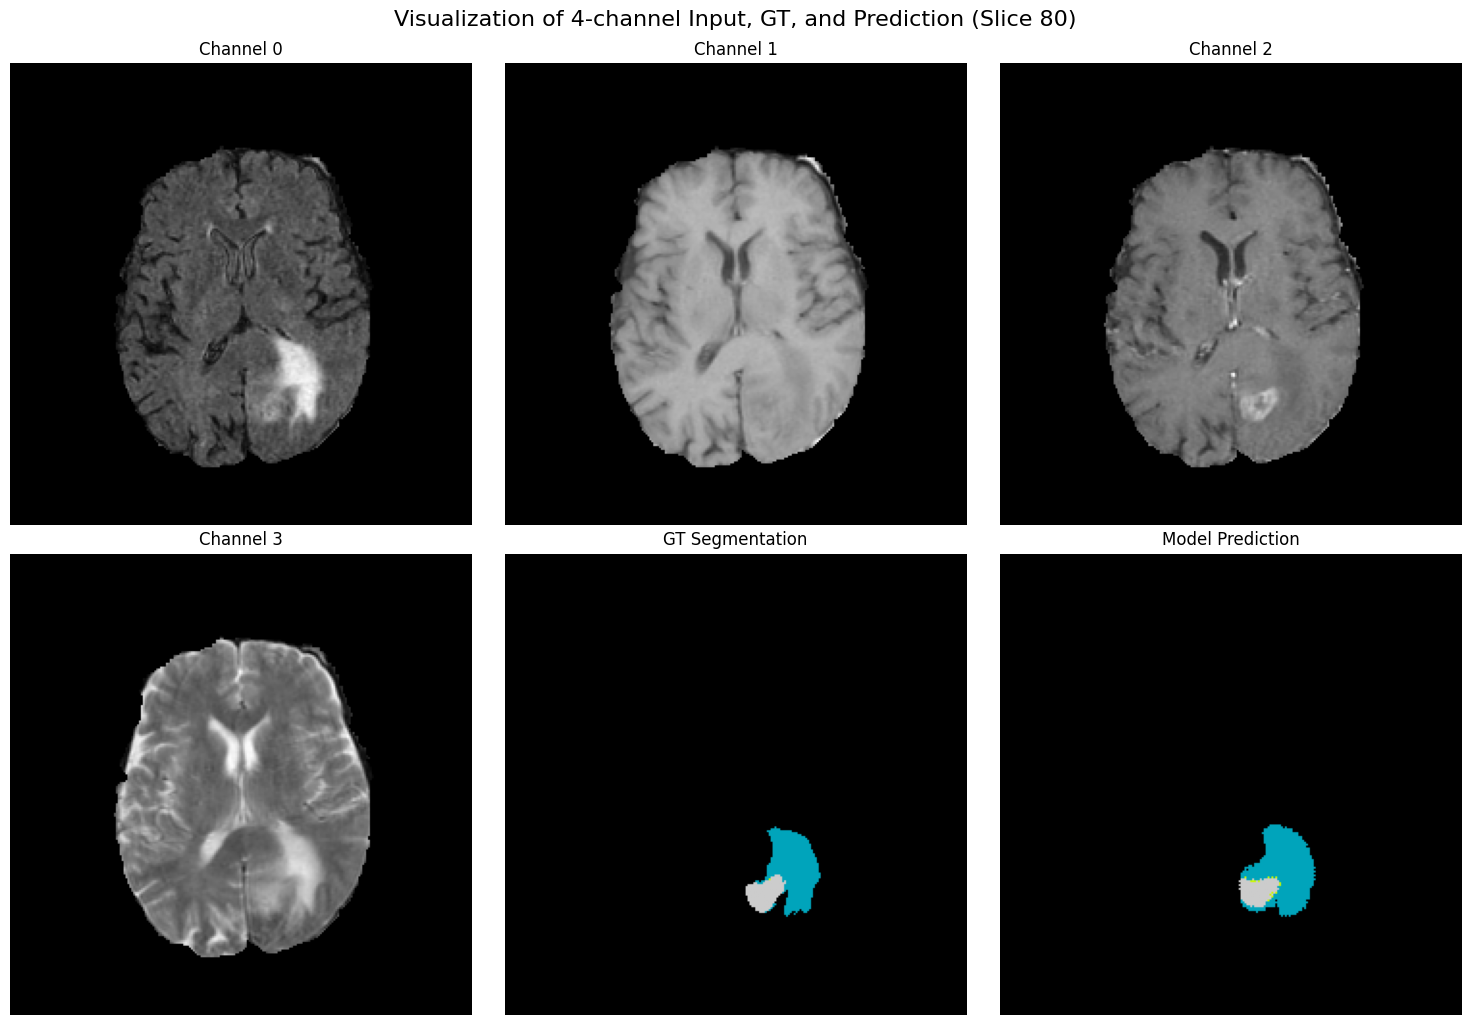

In [ ]:
import numpy as np

sample_data = next(iter(test_loader))

image_tensor = sample_data["image"].to(device)  # [B, C=4, H, W, D]
label_tensor = sample_data["label"].to(device)  # [B, 1, H, W, D]

model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    preds = torch.argmax(outputs, dim=1)  # [B, H, W, D]

mid_slice = image_tensor.shape[-1] // 2

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
channel_titles = ['Channel 0', 'Channel 1', 'Channel 2', 'Channel 3']

for i in range(4):
    channel_slice = image_tensor[0, i, :, :, mid_slice].cpu().numpy()
    axes[i // 3, i % 3].imshow(np.rot90(channel_slice), cmap='gray')
    axes[i // 3, i % 3].set_title(channel_titles[i])
    axes[i // 3, i % 3].axis('off')

gt_slice = label_tensor[0, 0, :, :, mid_slice].cpu().numpy()
axes[1, 1].imshow(np.rot90(gt_slice), cmap='nipy_spectral')
axes[1, 1].set_title('GT Segmentation')
axes[1, 1].axis('off')

pred_slice = preds[0, :, :, mid_slice].cpu().numpy()
axes[1, 2].imshow(np.rot90(pred_slice), cmap='nipy_spectral')
axes[1, 2].set_title('Model Prediction')
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle(f"Visualization of 4-channel Input, GT, and Prediction (Slice {mid_slice})", y=1.02, fontsize=16)
plt.show()


In [ ]:
from tqdm import tqdm

model.eval()
total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for batch_data in tqdm(test_loader):
        images, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        outputs = model(images)

        loss = loss_function(outputs, labels)

        total_loss += loss.item()
        num_batches += 1

avg_loss = total_loss / num_batches

print(f"Average Loss on the Test Set: {avg_loss:.4f}")


100%|██████████| 17/17 [01:45<00:00,  6.19s/it]

Average Loss on the Test Set: 0.6117
